<a id='top'></a>
![TG profile][def]

[def]: https://img.shields.io/badge/t.me/seikin__alexey-blue?logo=telegram&logoColor=yellow
<p align="center">
  <img src="https://img.shields.io/badge/python-3670A0?style=for-the-badge&logo=python&logoColor=ffdd54" style="border-radius: 5px;" />
  <img src="https://img.shields.io/badge/pandas-%23150458.svg?style=for-the-badge&logo=pandas&logoColor=white" style="border-radius: 5px;" />
  <img src="https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white" style="border-radius: 5px;" />
</p>

<h1 align="center">Проверка статистических гипотез при анализе тениссных партий</h1>
<p align="center">В этом проекте на практике рассматривается применение статистических тестов в анализе партий по теннису.
Цель проекта - набрать максимальное количество баллов (20 баллов) по критериям заказчика.</p>

Подробное описание смотри в readme.md

## План работы по каждой задаче
- Шаг 1: Подготовка данных
    - Загрузка данных
    - Предобработка датасетов (Пропуски и явные дубликаты)
  
- Шаг 2: Формулирование гипотез
    - Нулевая гипотеза
    - Альтернативная гипотеза

- Шаг 3: Определение характеристик выборки
    - Размер, среднее, дисперсия и тд

- Шаг 4: Определение подходящих тестов
    - Обоснование выбора теста
    - Проведение теста
    - Принятие или отклонение нулевой гипотезы

- Шаг 5: Формулирование выводов


## Импорты

In [1]:
# Импорты библиотек для проекта
import requests
from bs4 import BeautifulSoup
import re

import os
import glob

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats # библиотека для расчетов
import statsmodels.api as sm # для qq plot

from scipy.stats import shapiro # тест на нормальность распределения Шапиро
from scipy.stats import normaltest # тест на нормальность распределения Деагостино
from scipy.stats import mannwhitneyu # тест Манна-Уитни непараметрический тест
from scipy.stats import ttest_ind # t-тест
from statsmodels.stats.weightstats import ztest # z-тест
from scipy.stats import kruskal 
from scipy import stats # библиотека для расчетов
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

C:\Users\user\AppData\Local\Temp\ipykernel_6856\2616906813.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Подготовка данных для всех задач

In [2]:
# Загрузка файлов из репозитория GitHub в локальную папку

# import requests
# from bs4 import BeautifulSoup
# import re
# import os

# URL репозитория
repo_url = 'https://github.com/JeffSackmann/tennis_atp'

# Папка, в которой находятся файлы
folder_path = 'blob/master/'

# Директория для сохранения файлов
save_dir = 'github_data'

# Создаем директорию, если она не существует
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Создаем сессию requests
with requests.Session() as session:
    # Получаем страницу репозитория с файлами
    response = session.get(f'{repo_url}/{folder_path}')
    if response.ok:
        # Используем BeautifulSoup для парсинга HTML
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Ищем все ссылки на csv файлы, которые соответствуют маске
        regex = re.compile(r'atp_matches_\d{4}\.csv')
        for a in soup.find_all('a', href=True):
            if regex.match(a.text):
                # Строим URL файла
                file_url = f'https://github.com{a["href"]}'
                # Превращаем ссылку на просмотр в ссылку на скачивание
                raw_url = file_url.replace('/blob/', '/raw/')
                # Скачиваем файл
                file_response = session.get(raw_url)
                if file_response.ok:
                    # Сохраняем содержимое файла
                    file_name = os.path.join(save_dir, a.text)
                    with open(file_name, 'wb') as file:
                        file.write(file_response.content)
                        print(f'Downloaded {file_name}')
                else:
                    print(f'Failed to download {a.text}')
    else:
        print('Failed to retrieve the repository page')

Downloaded github_data\atp_matches_1968.csv
Downloaded github_data\atp_matches_1968.csv
Downloaded github_data\atp_matches_1969.csv
Downloaded github_data\atp_matches_1969.csv
Downloaded github_data\atp_matches_1970.csv
Downloaded github_data\atp_matches_1970.csv
Downloaded github_data\atp_matches_1971.csv
Downloaded github_data\atp_matches_1971.csv
Downloaded github_data\atp_matches_1972.csv
Downloaded github_data\atp_matches_1972.csv
Downloaded github_data\atp_matches_1973.csv
Downloaded github_data\atp_matches_1973.csv
Downloaded github_data\atp_matches_1974.csv
Downloaded github_data\atp_matches_1974.csv
Downloaded github_data\atp_matches_1975.csv
Downloaded github_data\atp_matches_1975.csv
Downloaded github_data\atp_matches_1976.csv
Downloaded github_data\atp_matches_1976.csv
Downloaded github_data\atp_matches_1977.csv
Downloaded github_data\atp_matches_1977.csv
Downloaded github_data\atp_matches_1978.csv
Downloaded github_data\atp_matches_1978.csv
Downloaded github_data\atp_match

In [3]:
# Сборка датасетов в датафрейм

# Указываем путь к папке с данными
folder_path = 'github_data'  # Укажи актуальный путь

# Получаем список всех CSV файлов, соответствующих маске 'atp_matches_*.csv'
csv_files = glob.glob(os.path.join(folder_path, 'atp_matches_*.csv'))

# Читаем каждый CSV файл и добавляем его в список датафреймов
df_list = [pd.read_csv(file) for file in csv_files]

# Объединяем все датафреймы в один, игнорируя индексы и используя внешнее объединение
combined_df = pd.concat(df_list, ignore_index=True, join='outer')

# Извлекаем год из столбца tourney_id и преобразуем его в целочисленный тип
combined_df['year'] = combined_df['tourney_id'].str.extract(r'(\d{4})').astype(int)

# Сохраняем объединенный датафрейм в файл 'full_data/combined_atp_matches.csv' без индексов
combined_df.to_csv('full_data/combined_atp_matches.csv', index=False)

In [4]:
combined_df = pd.read_csv('full_data/combined_atp_matches.csv')

In [5]:
combined_df.shape

(191920, 50)

## Кастомные функции

### Кастомные функции для предобработки

In [6]:
def df_info(df):
    """
    Функция для получения информации о датафрейме.

    Args:
        df (pandas.DataFrame): Входной датафрейм.

    Returns:
        None
    """
    len_df = len(df)
    count = 0
    na_col_name = []
    na_col_size = []
    unique_list = []

    for col in df.columns:
        notnull = df[col].notna().sum()
        if notnull < len_df:
            count += 1
        if df[col].isna().sum() > 0:
            na_col_name.append(col)
            col_size = df[col].isna().sum() / len(df) * 100
            na_col_size.append(col_size)

        unique_list.append(len(df[col].unique()))

    pivot = pd.DataFrame(data=unique_list, index=df.columns, columns=['Уникальные значения'])

    print(f'Количество записей: \t {len_df}')
    print(f'Количество столбцов: \t {len(df.columns)}')
    print(f'Явных дубликатов: \t {df.duplicated().sum()}')
    print(f'Пропуски присутствуют в {count} столбцах из {len(df.columns)}:')
    display(pd.DataFrame(na_col_size, index=na_col_name, columns=['Пропущено %']).sort_values(by='Пропущено %', ascending=False))
    print('Обобщенная информация:')
    display(df.info(verbose=False))
    print('Первые 3 строки:')
    display(df.head(3))

In [7]:
def low_information_features(df):
    """
    Функция для определения неинформативных признаков в датафрейме.
    
    Признаки считаются неинформативными, если одно значение встречается более чем в 95%
    случаев или если более 95% значений являются уникальными.
    
    Args:
        df (pandas.DataFrame): Входной датафрейм.
        
    Returns:
        Union[list, str]: Список неинформативных признаков или сообщение об их отсутствии.
    """
    low_information_cols = []  # инициализация списка для неинформативных признаков

    for col in df.columns:  # цикл по всем столбцам
        top_freq = df[col].value_counts(normalize=True).max()  # наибольшая относительная частота в признаке
        nunique_ratio = df[col].nunique() / df[col].count()  # доля уникальных значений от размера признака

        # сравниваем наибольшую частоту с порогом 95%
        if top_freq > 0.95:
            low_information_cols.append(col)  # добавляем столбец в список
            # выводим информацию о признаке
            print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')

        # сравниваем долю уникальных значений с порогом 95%
        if nunique_ratio > 0.95:
            low_information_cols.append(col)  # добавляем столбец в список
            # выводим информацию о признаке
            print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

    if not low_information_cols:
        return "Нет неинформативных признаков"
    else:
        return low_information_cols  # возвращаем список неинформативных признаков

In [8]:
def plot_missing_values(df):
    """
    Функция для построения столбчатой диаграммы, отображающей процент пропущенных значений в каждом столбце датафрейма.

    Args:
        df (pandas.DataFrame): Входной датафрейм.

    Returns:
        None
    """
    # Вычисление процента пропущенных значений
    nans = 100 * df.isnull().mean().sort_values(ascending=False)[df.isnull().mean().sort_values(ascending=False) > 0]

    # Построение столбчатой диаграммы
    nans.plot(
        kind='bar', 
        logy=False,
        figsize=(10,5),
        title='Соотношение пропусков, %'
    )

### Кастомные функции для графического описаниея распределений признака для каждой выборки

In [9]:
def plot_sample_data(sample_data_a, sample_data_b, title_a='a', title_b='b'):
    """
    Функция для создания графиков QQ, гистограмм и boxplot для двух выборок.

    Args:
    sample_data_a: Первая выборка данных
    sample_data_b: Вторая выборка данных
    title_a: Название для первой выборки
    title_b: Название для второй выборки
    """
    fig, axs = plt.subplots(3, 2, figsize=(10, 15))
    plt.subplots_adjust(hspace=0.5)

    # Создание графика QQ-графика для sample_data_a
    # sm.qqplot(sample_data_a, line='45', ax=axs[0, 0])
    stats.probplot(sample_data_a, plot=axs[0, 0]) # qq plot
    axs[0, 0].set_title(f'График QQ для {title_a}')

    # Создание графика QQ-графика для sample_data_b
    # sm.qqplot(sample_data_b, line='45', ax=axs[0, 1])
    stats.probplot(sample_data_b, plot=axs[0, 1]) # qq plot
    axs[0, 1].set_title(f'График QQ для {title_b}')

    # Создание гистограммы для sample_data_a
    sns.histplot(sample_data_a, kde=True, ax=axs[1, 0])
    axs[1, 0].set_title(f'Гистограмма для {title_a}')

    # Создание гистограммы для sample_data_b
    sns.histplot(sample_data_b, kde=True, ax=axs[1, 1])
    axs[1, 1].set_title(f'Гистограмма для {title_b}')
    
    # Создание графика boxplot для sample_data_a с отрисовкой среднего и медианы
    sns.boxplot(sample_data_a, ax=axs[2, 0], showmeans=True, meanline=True, showfliers=False)
    axs[2, 0].set_title(f'Boxplot для {title_a} \n mean: {np.mean(sample_data_a):.2f}, median: {np.median(sample_data_a):.2f}')
    
    # Создание графика boxplot для sample_data_b с отрисовкой среднего и медианы
    sns.boxplot(sample_data_b, ax=axs[2, 1], showmeans=True, meanline=True, showfliers=False)
    axs[2, 1].set_title(f'Boxplot для {title_b} \n mean: {np.mean(sample_data_b):.2f}, median: {np.median(sample_data_b):.2f}')

    plt.show()

### Тест Шапиро на нормальность

In [10]:
def shapiro_test(sample_a, sample_b, alpha=0.05):
    H0 = 'Распределения в обеих группах нормальные'
    H1 = 'Распределение в одной или обеих группах отлично от нормального'

    shapiro_result_a = shapiro(sample_a)
    shapiro_result_b = shapiro(sample_b)

    print(f'alpha: {alpha}')
    print('p-value sample A', round(shapiro_result_a.pvalue, 2))
    print('p-value sample B', round(shapiro_result_b.pvalue, 2))

    if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
        print("Отвергаем нулевую гипотезу H0: {}".format(H0))
        print("Альтернативная гипотеза. H1: {}".format(H1))
    else:
        print("Принимаем нулевую гипотезу. {}".format(H0))

# Пример использования:
# shapiro_test(more20['deviation'], less20['deviation'], alpha=0.05)

## Предобработка для всех задач

### Неинформативные признаки

In [11]:
low_information_features(combined_df)

'Нет неинформативных признаков'

### Пропуски

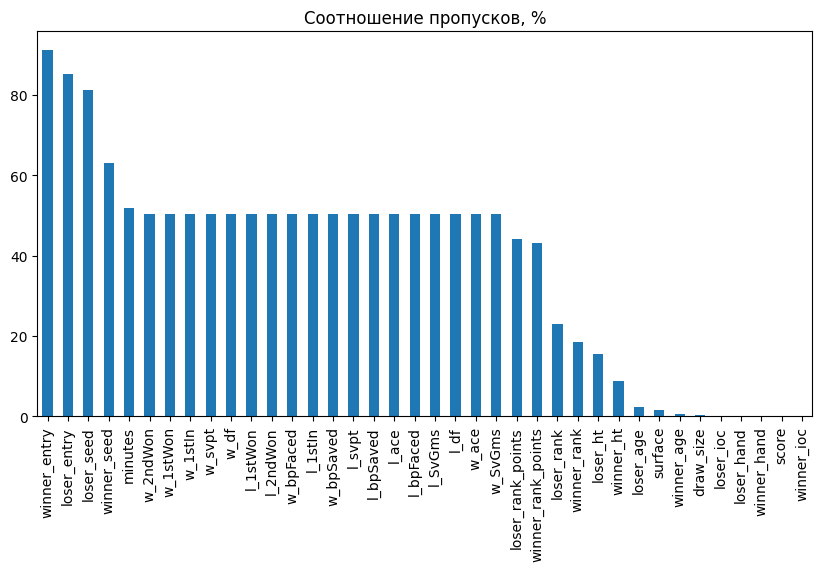

In [12]:
plot_missing_values(combined_df)

In [13]:
# удаляем столбец если у него 60% или более значений отсутствует
combined_df = combined_df.dropna(axis=1, thresh=(0.4 * combined_df.shape[0]))

In [14]:
# Общий обзор сборного датасета
df_info(combined_df)

Количество записей: 	 191920
Количество столбцов: 	 46
Явных дубликатов: 	 0
Пропуски присутствуют в 34 столбцах из 46:


,Пропущено %
minutes,51.924239
w_2ndWon,50.482493
w_1stIn,50.482493
l_bpFaced,50.482493
l_bpSaved,50.482493
w_bpFaced,50.482493
l_2ndWon,50.482493
l_1stWon,50.482493
l_1stIn,50.482493
l_svpt,50.482493


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191920 entries, 0 to 191919
Columns: 46 entries, tourney_id to year
dtypes: float64(28), int64(6), object(12)
memory usage: 67.4+ MB


None

Первые 3 строки:


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,1968-2029,Dublin,Grass,32.0,A,19680708,270,112411,Doug Smith,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
1,1968-2029,Dublin,Grass,32.0,A,19680708,271,126914,Louis Pretorius,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
2,1968-2029,Dublin,Grass,32.0,A,19680708,272,209523,Cecil Pedlow,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968


## Задача_01_a

> Проверьте следующие утверждения - Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);

Для выполнения данного задания можно использовать следующие шаги:
* Сформировать две выборки игроков: первая выборка - игроки с рангом, отличающимся более чем на 20 позиций от противника, вторая - игроки с близким рангом к противнику (отличие менее 20 позиций). Например: 
`df_rank_1['higher_rank_win'] = (df_rank_1['winner_rank'] - df_rank_1['loser_rank']) > 20`
* Для каждой игры в выборках посчитать ожидаемое количество побед при случайном исходе. Это можно сделать, умножив количество сыгранных игр на вероятность выигрыша 0,5 (при равных шансах для каждого игрока).
* Посчитать фактическое количество побед для каждого игрока в выборках.
* Вычислить отклонение фактического количества побед от ожидаемого для каждого игрока.
* Рассчитать среднее отклонение для каждой выборки.
* Сравнить средние отклонения между выборками. Если в первой выборке (ранг выше более чем на 20 позиций) среднее отклонение значительно выше, чем во второй выборке, то это подтверждает гипотезу о большей вероятности выигрыша у игроков с более высоким рангом.


Например:

Игрок А сыграл 100 игр, его ожидаемое количество побед 100 * 0,5 = 50. Фактическое количество побед 62. Отклонение +12.
Игрок B сыграл 80 игр, ожидаемое 80 * 0,5 = 40 побед. Фактическое 45 побед. Отклонение +5.
Рассчитываем среднее отклонение для выборки как сумму всех отклонений, деленную на количество игроков в выборке.

In [15]:
# Создание выборки к задаче
combined_df = pd.read_csv('full_data/combined_atp_matches.csv')
task_01_a = combined_df[['year', 'match_num', 'winner_id', 'winner_rank', 'loser_id', 'loser_rank']].dropna()
task_01_a['rank_diff_more20'] = np.where(abs(task_01_a['winner_rank'] - task_01_a['loser_rank']) > 20, 1, 0)

# Размеры выборок
task_01_a.rank_diff_more20.value_counts()


rank_diff_more20
1    106767
0     37093
Name: count, dtype: int64

In [16]:
df_info(task_01_a)

Количество записей: 	 143860
Количество столбцов: 	 7
Явных дубликатов: 	 57
Пропуски присутствуют в 0 столбцах из 7:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 143860 entries, 18086 to 191919
Columns: 7 entries, year to rank_diff_more20
dtypes: float64(2), int32(1), int64(4)
memory usage: 8.2 MB


None

Первые 3 строки:


,year,match_num,winner_id,winner_rank,loser_id,loser_rank,rank_diff_more20
18086,1973,1,100119,1.0,100129,88.0,1
18087,1973,2,100304,193.0,100067,71.0,1
18088,1973,3,100135,39.0,100376,118.0,1


In [17]:
def calculate_player_performance_metrics(task_01_a):
   """
   Функция для расчёта метрик производительности игроков

   Parameters:
   task_01_a (DataFrame): DataFrame с информацией о победах и поражениях

   Returns:
   DataFrame: DataFrame с метриками производительности игроков
   """
   wins_count = task_01_a['winner_id'].value_counts()
   losses_count = task_01_a['loser_id'].value_counts()
   total_games = wins_count.add(losses_count, fill_value=0).astype(int)
   player_performance_df = pd.DataFrame({
       'player_id': total_games.index,
       'wins': wins_count,
       'losses': losses_count,
       'total': total_games
   }).reset_index(drop=True)
   player_performance_df['wins'].fillna(0, inplace=True)
   player_performance_df['losses'].fillna(0, inplace=True)
   player_performance_df['wins'] = player_performance_df['wins'].astype(int)
   player_performance_df['losses'] = player_performance_df['losses'].astype(int)
   player_performance_df['expected_wins'] = player_performance_df['total'] * 0.5
   player_performance_df['deviation'] = player_performance_df['wins'] - player_performance_df['expected_wins']
   return player_performance_df.sort_values(by='total', ascending=False)

In [18]:
more20 = calculate_player_performance_metrics(task_01_a[task_01_a['rank_diff_more20'] == 1])
less20 = calculate_player_performance_metrics(task_01_a[task_01_a['rank_diff_more20'] == 0])


In [19]:
more20.head(3)

,player_id,wins,losses,total,expected_wins,deviation
2028,103819,821,103,924,462.0,359.0
2397,104745,694,88,782,391.0,303.0
1150,101736,614,132,746,373.0,241.0


In [20]:
less20.head(3)

,player_id,wins,losses,total,expected_wins,deviation
1157,103819,441,177,618,309.0,132.0
1330,104925,437,141,578,289.0,148.0
1306,104745,385,139,524,262.0,123.0


In [21]:
# Рассчитать среднее отклонение для каждой выборки
mean_dev_more20 = more20.deviation.abs().mean()
mean_dev_less20 = less20.deviation.abs().mean()

print(f'Cреднее отклонение для выборки more20: {round(mean_dev_more20, 2)}')
print(f'Cреднее отклонение для выборки less20: {round(mean_dev_less20, 2)}')


# Если в первой выборке (ранг выше более чем на 20 позиций) среднее отклонение значительно выше, 
# чем во второй выборке, то это подтверждает гипотезу о 
# большей вероятности выигрыша у игроков с более высоким рангом.

Cреднее отклонение для выборки more20: 7.23
Cреднее отклонение для выборки less20: 2.97


### Графическое описание распределений признака `deviation` для каждой выборки

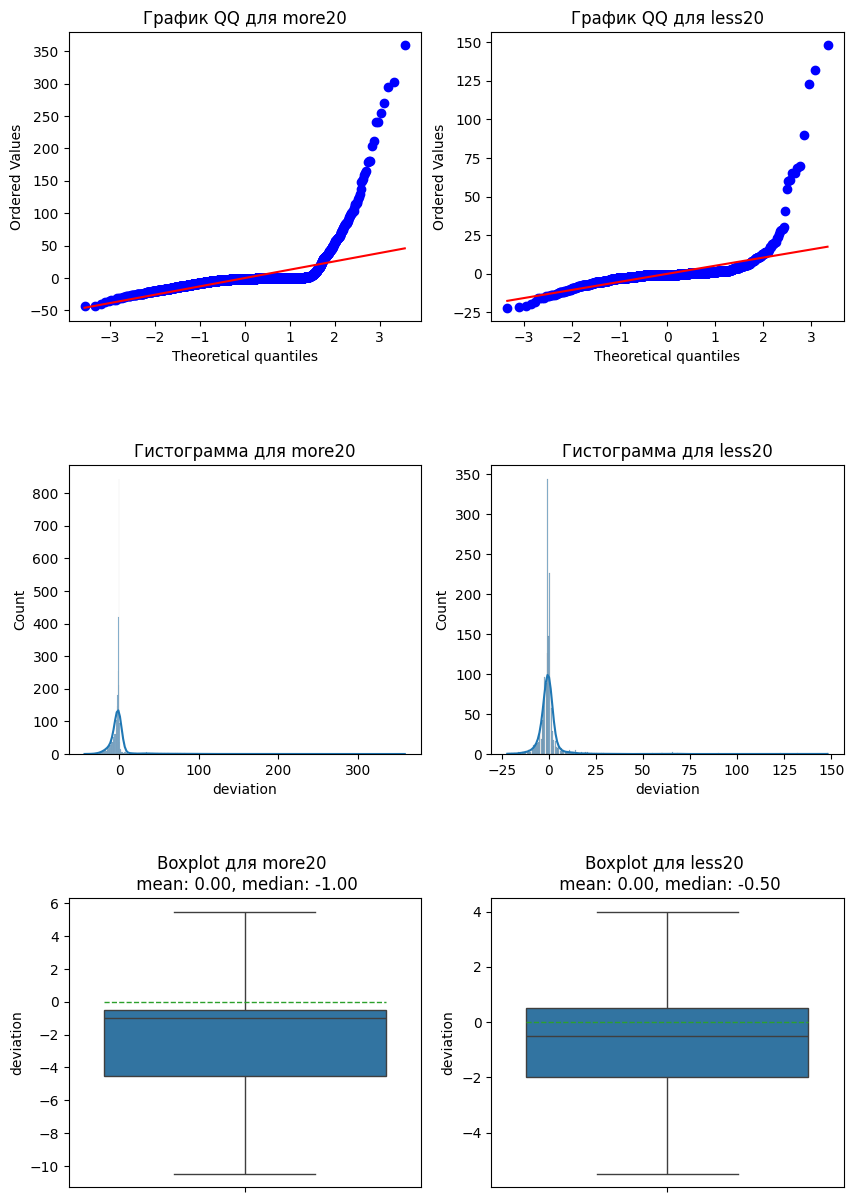

In [22]:
plot_sample_data(more20.deviation, less20.deviation, title_a='more20', title_b='less20')

#### Статистический тест на нормальность

In [23]:
shapiro_test(more20.deviation, less20.deviation, alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


#### Обоснование выбора теста: критерий Уилкоксона (Манна-Уитни)
Если выборки формируются путем разделения одной родительской выборки на основе значения одного из признаков, то они могут считаться зависимыми в том смысле, что обе группы изначально были частью одной и той же совокупности. 

Однако, если после разделения каждая из подвыборок не содержит парных наблюдений (например, один и тот же игрок в обеих подвыборках), то они всё же будут считаться независимыми в контексте статистического анализа.

Когда вы разделяете выборку на две группы на основе ранга игрока (например, игроки с рангом выше на 20 позиций и все остальные), и сравниваете отклонения реальных побед от ожидаемых между этими двумя группами, вы фактически имеете дело с двумя независимыми выборками.

В таком случае, чтобы сравнить средние отклонения между двумя независимыми выборками, можно использовать t-тест для независимых выборок (если данные удовлетворяют условиям применения t-теста), или непараметрический U-тест Манна-Уитни, если предположения для t-теста не выполняются

Поскольку наши данные, не содержат парных наблюдений, а являются двумя отдельными группами из одной совокупности, можно выбрать между t-тестом и U-тестом Манна-Уитни в зависимости от распределения данных.

Учитывая, что проведенный тест Шапиро и тест Деагостино не указали на нормальность распределений - подходит только тест Мана-Уитни.

#### Тест Мана-Уитни
Нулевая гипотеза (H0): 
Нет статистически значимой разницы в медианах отклонений между двумя независимыми выборками. 
Это означает, что любые различия между выборками могут быть результатом случайности.

Альтернативная гипотеза (H1): 
Существует статистически значимая разница в медианах отклонений между двумя независимыми выборками. 
Это указывает на то, что наблюдаемые различия маловероятно являются случайными и что 
одна из групп имеет тенденцию к более высоким или низким отклонениям.

выбора параметра alternative:

* 'two-sided' используется, если вы хотите проверить, отличаются ли выборки вообще (в любом направлении).
* 'less' используется, если вы предполагаете, что медиана первой выборки меньше медианы второй.
* 'greater' используется, если вы предполагаете, что медиана первой выборки больше медианы второй.

In [24]:
# Тест Мана-Уитни
sample_a = more20.deviation
sample_b = less20.deviation

# Уровень значимости
alpha = 0.05

# Проведение одностороннего U-теста Манна-Уитни
stat, p = mannwhitneyu(sample_a, sample_b, alternative='greater')

# Вывод результатов
print(f'U-статистика: {stat}')
print(f'p-значение: {p}')

# Формулировка гипотез
H0 = 'Среднее отклонений для more20 не больше медианы для выборки less20'
H1 = 'Среднее отклонений для more20 больше медианы для выборки less20'
print(f'Нулевая гипотеза (вероятность победы не выше в группе с разницей рангов >20):{H0}')
print(f'Альтернативная гипотеза (вероятность победы выше в группе с разницей рангов >20):{H1}')

# Сравнение p-значения с уровнем значимости
if p < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0} при a = {alpha}.')
    print(f'Принимаем альтернативную гипотезу: {H1} при a = {alpha}.')
else:
    print(f'Не отвергаем нулевую гипотезу: {H0} при a = {alpha}.')

U-статистика: 2221913.5
p-значение: 1.0
Нулевая гипотеза (вероятность победы не выше в группе с разницей рангов >20):Среднее отклонений для more20 не больше медианы для выборки less20
Альтернативная гипотеза (вероятность победы выше в группе с разницей рангов >20):Среднее отклонений для more20 больше медианы для выборки less20
Не отвергаем нулевую гипотезу: Среднее отклонений для more20 не больше медианы для выборки less20 при a = 0.05.


#### Вывод по задаче_01_а

Проверка тестом Мана-Уитни:

* Нулевая гипотеза (вероятность победы не выше в группе с разницей рангов >20):Среднее отклонений для more20 не больше среднего для выборки less20
* Альтернативная гипотеза (вероятность победы выше в группе с разницей рангов >20):Среднее отклонений для more20 больше среднего для выборки less20
* Не отвергаем нулевую гипотезу: Среднее отклонений для more20 не больше медианы для выборки less20 при a = 0.05.

## Задача_01_b
>Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

В данном случае для проверки статистической значимости гипотезы о том, что вероятность победы игроков с рангами, отличающимися не более чем на 5 позиций, будет значительно отличаться от предыдущего случая (ранги различаются более чем на 20 позиций), то есть надо сделать выборку в случае если ранг отличается на 5 позиций. Нужно сравнить среднее количество побед между двумя группами.

In [25]:
# Создание выборки к задаче
combined_df = pd.read_csv('full_data/combined_atp_matches.csv')
task_01_b = combined_df[['year', 'match_num', 'winner_id', 'winner_rank', 'loser_id', 'loser_rank']].dropna()

# Создание бинарного признака window5, который указывает, 
# попадает ли разница рангов в интервал [-5, 5]
task_01_b['window5'] = task_01_b.apply(
    lambda row: 'in' if -5 <= (row['winner_rank'] - row['loser_rank']) <= 5 else 'out', 
    axis=1
)
# check
task_01_b.window5.value_counts()

window5
out    133840
in      10020
Name: count, dtype: int64

In [26]:
df_info(task_01_b)

Количество записей: 	 143860
Количество столбцов: 	 7
Явных дубликатов: 	 57
Пропуски присутствуют в 0 столбцах из 7:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 143860 entries, 18086 to 191919
Columns: 7 entries, year to window5
dtypes: float64(2), int64(4), object(1)
memory usage: 8.8+ MB


None

Первые 3 строки:


,year,match_num,winner_id,winner_rank,loser_id,loser_rank,window5
18086,1973,1,100119,1.0,100129,88.0,out
18087,1973,2,100304,193.0,100067,71.0,out
18088,1973,3,100135,39.0,100376,118.0,out


In [27]:
# Фильтрация записей с 1980 по 2022 год
filtered_df = task_01_b[(task_01_b['year'] >= 1984) & (task_01_b['year'] <= 2022)]

# Группировка по 'winner_id', 'year' и 'window5', подсчет количества побед
win_counts = filtered_df.groupby(['winner_id', 'year', 'window5']).size().reset_index(name='win_count')

# Считаем среднее количество побед
average_wins = win_counts.groupby(['year', 'window5'])['win_count'].mean().reset_index()

# Разделение среднего количества побед на группы 'in' и 'out'

average_wins_in = average_wins[average_wins['window5'] == 'in'].reset_index(drop=True)
average_wins_out = average_wins[average_wins['window5'] == 'out'].reset_index(drop=True)

In [28]:
win_counts.head(3)

,winner_id,year,window5,win_count
0,100119,1985,out,1
1,100144,1984,out,1
2,100144,1985,out,1


In [29]:
df_info(average_wins_in)


Количество записей: 	 39
Количество столбцов: 	 3
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 3:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Columns: 3 entries, year to win_count
dtypes: float64(1), int64(1), object(1)
memory usage: 1.0+ KB


None

Первые 3 строки:


,year,window5,win_count
0,1984,in,1.873563
1,1985,in,1.966292
2,1986,in,2.144330


In [30]:
df_info(average_wins_out)

Количество записей: 	 39
Количество столбцов: 	 3
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 3:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Columns: 3 entries, year to win_count
dtypes: float64(1), int64(1), object(1)
memory usage: 1.0+ KB


None

Первые 3 строки:


,year,window5,win_count
0,1984,out,9.740000
1,1985,out,10.194719
2,1986,out,9.925170


### Графическое описание распределений признака `win_count` для каждой выборки

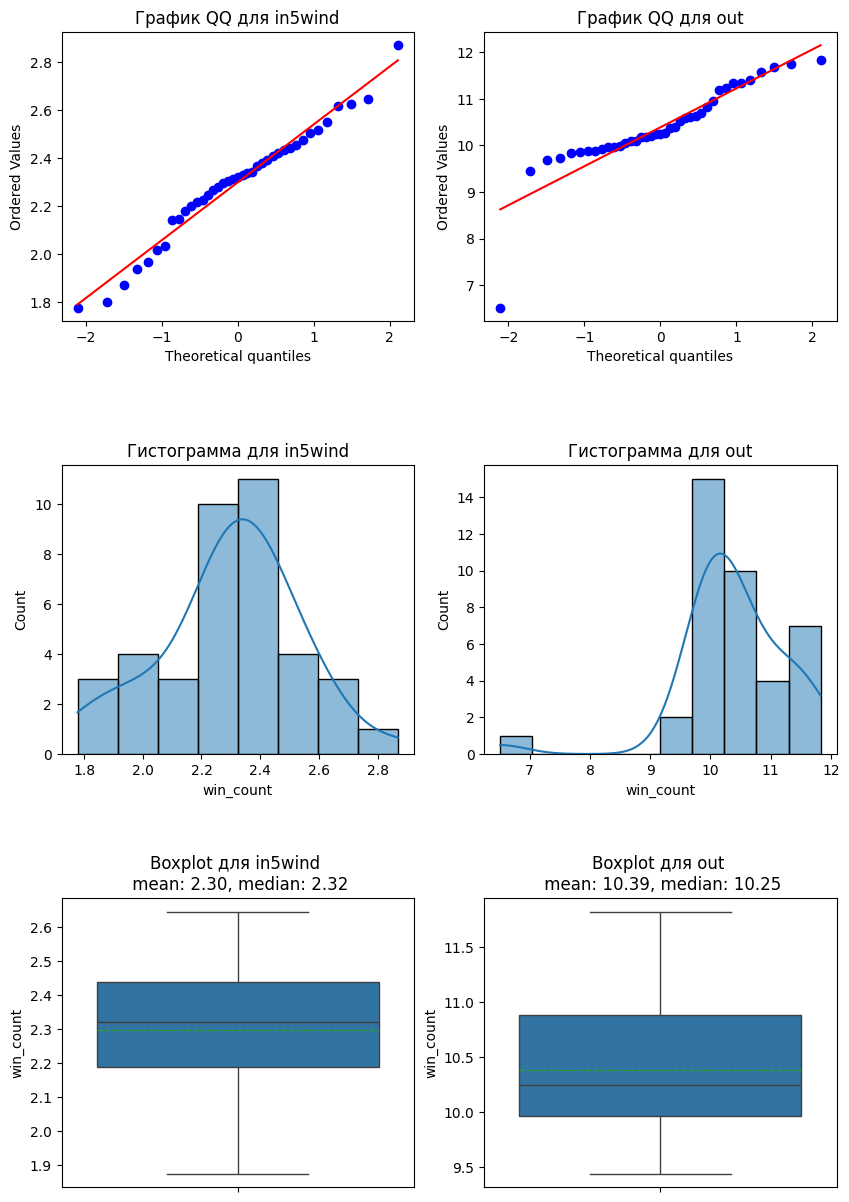

In [31]:
plot_sample_data(average_wins_in.win_count, average_wins_out.win_count, title_a='in5wind', title_b='out')

### Статистический тест на нормальность

In [32]:
shapiro_test(average_wins_in.win_count, average_wins_out.win_count, alpha=0.05)

alpha: 0.05
p-value sample A 0.57
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [33]:
# Среднее количество побед в группе in5window
average_wins_in.win_count.mean()

2.299102049249689

In [34]:
# Среднее количество побед в группе out
average_wins_out.win_count.mean()

10.389651533600555

### Статтест Манна-Уитни

`Тест Манна-Уитни (U-тест)` выбран для сравнения средних значений выборок, так как он подходит для независимых выборок небольшого размера и не предполагает нормальное распределение данных. Также, он позволяет провести одностороннюю проверку гипотезы о том, что среднее значение в одной выборке больше среднего значения в другой выборке.

In [35]:
# Формулировка гипотез
H0 = 'Среднее количество побед в группе out не больше среднего в группе in'
H1 = 'Среднее количество побед в группе out больше среднего в группе in'

# Уровень значимости
alpha = 0.05

# Проведение одностороннего U-теста Манна-Уитни
stat, p = mannwhitneyu(average_wins_in.win_count, average_wins_out.win_count, alternative='less')

# Вывод результатов
print(f'U-статистика: {stat}')
print(f'p-значение: {p}')

# Сравнение p-значения с уровнем значимости
if p < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0}')
    print(f'Принимаем альтернативную гипотезу: {H1}')
else:
    print(f'Принимаем нулевую гипотезу: {H0}')

U-статистика: 0.0
p-значение: 1.5393187778399125e-14
Отвергаем нулевую гипотезу: Среднее количество побед в группе out не больше среднего в группе in
Принимаем альтернативную гипотезу: Среднее количество побед в группе out больше среднего в группе in


### Вывод по задаче 01 b

Вывод: 

Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться (вероятность победы ниже) от гипотезы из предыдущего случая (там разницы нет). Для формирования репрезентативной выборки сделано усредненние побед всех игроков по годам.

## Задача_02
>Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

Количество сетов можно рассчитать, используя признак `score`

In [36]:
# Создание выборки к задаче
combined_df = pd.read_csv('full_data/combined_atp_matches.csv')
task_02 = combined_df[['year', 'score', 'winner_id']].dropna()

# Создаем признак с количеством сетов
# Учитываем только те сеты при подсчете, где явно указан счет партии в сете
def count_sets_with_scores(score):
    sets = re.findall(r'\d+-\d+', score)
    return len(sets)

task_02['sets_count'] = task_02['score'].apply(count_sets_with_scores)

# Образец разбиения score на количество сетов
unique_sets_count = sorted(task_02['sets_count'].unique())
for count in unique_sets_count:
    print(f'Образец для количества сетов: {count}')
    display(task_02[task_02['sets_count'] == count].head(1))

df_info(task_02)

Образец для количества сетов: 0


,year,score,winner_id,sets_count
129,1968,W/O,100099,0


Образец для количества сетов: 1


,year,score,winner_id,sets_count
67,1968,1-0 RET,109825,1


Образец для количества сетов: 2


,year,score,winner_id,sets_count
0,1968,6-1 7-5,112411,2


Образец для количества сетов: 3


,year,score,winner_id,sets_count
5,1968,4-6 8-6 6-2,207073,3


Образец для количества сетов: 4


,year,score,winner_id,sets_count
32,1968,6-3 6-2 0-6 6-3,100099,4


Образец для количества сетов: 5


,year,score,winner_id,sets_count
43,1968,6-0 2-6 6-3 4-6 7-5,100282,5


Количество записей: 	 191911
Количество столбцов: 	 4
Явных дубликатов: 	 17938
Пропуски присутствуют в 0 столбцах из 4:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 191911 entries, 0 to 191919
Columns: 4 entries, year to sets_count
dtypes: int64(3), object(1)
memory usage: 7.3+ MB


None

Первые 3 строки:


,year,score,winner_id,sets_count
0,1968,6-1 7-5,112411,2
1,1968,6-1 6-1,126914,2
2,1968,6-2 6-2,209523,2


In [37]:
# Удаление полных дубликатов
task_02 = task_02.drop_duplicates()

# Образец разбиения score на количество сетов
unique_sets_count = sorted(task_02['sets_count'].unique())
for count in unique_sets_count:
    print(f'Образец для количества сетов: {count}')
    display(task_02[task_02['sets_count'] == count].head(1))

df_info(task_02)

Образец для количества сетов: 0


,year,score,winner_id,sets_count
129,1968,W/O,100099,0


Образец для количества сетов: 1


,year,score,winner_id,sets_count
67,1968,1-0 RET,109825,1


Образец для количества сетов: 2


,year,score,winner_id,sets_count
0,1968,6-1 7-5,112411,2


Образец для количества сетов: 3


,year,score,winner_id,sets_count
5,1968,4-6 8-6 6-2,207073,3


Образец для количества сетов: 4


,year,score,winner_id,sets_count
32,1968,6-3 6-2 0-6 6-3,100099,4


Образец для количества сетов: 5


,year,score,winner_id,sets_count
43,1968,6-0 2-6 6-3 4-6 7-5,100282,5


Количество записей: 	 173973
Количество столбцов: 	 4
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 4:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 173973 entries, 0 to 191919
Columns: 4 entries, year to sets_count
dtypes: int64(3), object(1)
memory usage: 6.6+ MB


None

Первые 3 строки:


,year,score,winner_id,sets_count
0,1968,6-1 7-5,112411,2
1,1968,6-1 6-1,126914,2
2,1968,6-2 6-2,209523,2


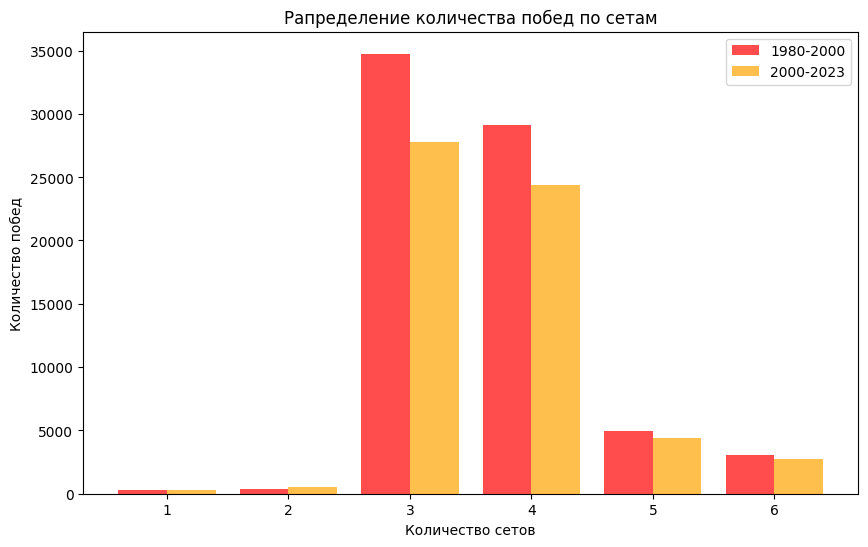

In [38]:
# Рапределение количества сетов, всего
# Фильтрация данных по годам
task_02_1980_2001 = task_02[(task_02['year'] >= 1980) & (task_02['year'] <= 2001)].reset_index(drop=True)
task_02_2002_2023 = task_02[(task_02['year'] > 2001) & (task_02['year'] <= 2023)].reset_index(drop=True)

# Создание позиций для баров
positions = range(1, max(task_02['sets_count']) + 2, 1)

# Построение гистограммы для каждой группы с разными цветами
plt.figure(figsize=(10, 6))
plt.bar([pos - 0.2 for pos in positions], 
        task_02_1980_2001['sets_count'].value_counts().sort_index(), 
        width=0.4, 
        color='red', 
        alpha=0.7, 
        label='1980-2000')
plt.bar([pos + 0.2 for pos in positions], 
        task_02_2002_2023['sets_count'].value_counts().sort_index(), 
        width=0.4, 
        color='orange', 
        alpha=0.7, 
        label='2000-2023')

plt.title('Рапределение количества побед по сетам')
plt.xlabel('Количество сетов')
plt.ylabel('Количество побед')
plt.legend()
plt.show()

### Графическое описание распределений признака для каждой выборки

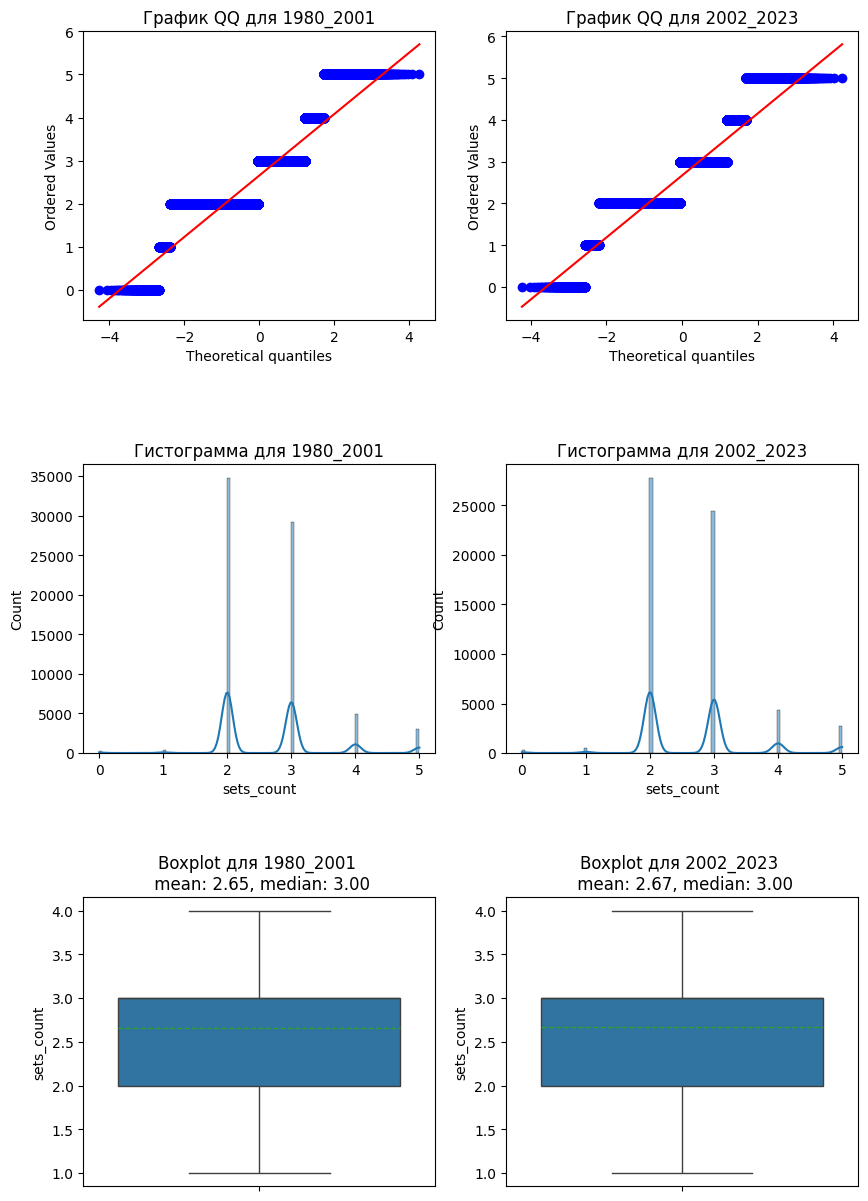

In [39]:
plot_sample_data(task_02_1980_2001.sets_count, task_02_2002_2023.sets_count, title_a='1980_2001', title_b='2002_2023')

In [40]:
# Сравнение среднего количества побед

print(f"Среднее количество сетов для побед в периоде 1980-2001: {task_02_1980_2001.sets_count.mean()}, общее количество партий: {len(task_02_1980_2001.sets_count)}")
print(f"Среднее количество сетов для побед в периоде 2002-2023: {task_02_2002_2023.sets_count.mean()}, общее количество партий: {len(task_02_2002_2023.sets_count)}")

Среднее количество сетов для побед в периоде 1980-2001: 2.6531740125141265, общее количество партий: 72558
Среднее количество сетов для побед в периоде 2002-2023: 2.668783561370551, общее количество партий: 60151


### Статистический тест на нормальность

In [41]:
shapiro_test(task_02_1980_2001.sets_count, task_02_2002_2023.sets_count, alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


Примем с работе, что выборки все же нормально распределены, на основании графического представления. QQ plot и boxplot отражают это наиболее ясно.

### Z тест

Обоснование выбора теста:

Z-тест подходит для сравнения средних двух независимых выборок, когда выполнены следующие условия:

Большой объем выборок: Для каждой из выборок количество наблюдений достаточно велико (обычно более 30), что позволяет применять Центральную предельную теорему.

Распределение выборочных средних близко к нормальному: Предполагается, что данные распределены нормально, или что из-за большого размера выборок распределение средних можно считать нормальным на основании Центральной предельной теоремы.

Известные или предполагаемые равные дисперсии: Значения в выборках должны иметь примерно одинаковые дисперсии. Если дисперсии сильно отличаются, следует использовать другие виды тестов (например, t-тест Уэлча).

Независимость выборок: Наблюдения в одной выборке не должны влиять на наблюдения в другой.
В вашем случае, сравнение среднего количества сетов для победы между двумя временными периодами (1980-2001 и 2002-2023) с большим количеством данных (60 000 наблюдений) подходит под эти критерии. Допущение о нормальности распределения усиливается благодаря большому размеру выборки и предположению о том, что выборочные средние будут распределены нормально.

Также, предполагается, что данные за разные годы независимы, что является важным условием для z-теста. И хотя дисперсии могли измениться со временем, z-тест может быть использован как первичная проверка различий между средними, особенно при больших объемах данных, когда влияние несоответствия дисперсий снижается.

Если дисперсии выборок неизвестны или предположение о равенстве дисперсий сомнительно, можно использовать t-тест с поправкой Уэлча, который не требует равенства дисперсий.

In [42]:
# Нулевая гипотеза: среднее значение первой выборки меньше или равно среднему значению второй выборки
# Альтернативная гипотеза: среднее значение первой выборки больше среднего значения второй выборки

# Проведем z-тест
z_stat, p_value = ztest(task_02_1980_2001.sets_count, task_02_2002_2023.sets_count, alternative='larger')

print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

# Установим уровень значимости, например, 0.05
alpha = 0.05

# Проверим нулевую гипотезу
if p_value < alpha:
    print("Отвергаем нулевую гипотезу - есть достаточные доказательства, что среднее первой выборки 1980_2001 больше среднего второй 2002_2023")
else:
    print("Не отвергаем нулевую гипотезу - нет достаточных доказательств считать среднее первой выборки 1980_2001 большим")

Z-statistic: -3.4641509089513445
P-value: 0.999734045988888
Не отвергаем нулевую гипотезу - нет достаточных доказательств считать среднее первой выборки 1980_2001 большим


### Вывод по задаче 02 

На основании графического распределения данных и вопреки результату теста Шапиро принимаем версию о нормальном распределении значений количества сетов в выборках.

Проведенный z тест позволяет утверждать - среднее значение первой выборки 1980_2001 меньше или равно среднему значению второй выборки 2002_2023.

Среднее количество сетов для любого игрока чтобы победить уменьшается со временем - не верно.

## Задача_03

У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным. Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

Чтобы сформировать датасет надо:
1. Фильтрация данных: Оставить только матчи, где значение в колонке best_of равно 5. Это можно сделать, создав новый фрейм данных, который содержит только строки, где df['best_of'] == 5.
2. Разделение данных на две группы: Разделите данные на две группы в зависимости от года матча. Одна группа должна содержать матчи с 1980 по 2001 год, а другая с 2002 по 2022 год. Это можно сделать с помощью логического индексирования по столбцу с годами.

In [43]:
# Создание выборки к задаче
combined_df = pd.read_csv('full_data/combined_atp_matches.csv')
task_03 = combined_df[['year', 'score', 'winner_id', 'best_of']].dropna()
task_03 = task_03[task_03.best_of == 5]
# Создаем признак с количеством сетов
# Учитываем только те сеты при подсчете, где явно указан счет партии в сете
def count_sets_with_scores(score):
    sets = re.findall(r'\d+-\d+', score)
    return len(sets)

task_03['sets_count'] = task_03['score'].apply(count_sets_with_scores)

# Образец разбиения score на количество сетов
unique_sets_count = sorted(task_03['sets_count'].unique())
for count in unique_sets_count:
    print(f'Образец для количества сетов: {count}')
    display(task_03[task_03['sets_count'] == count].head(1))

df_info(task_03)

Образец для количества сетов: 0


,year,score,winner_id,best_of,sets_count
233,1968,W/O,100085,5,0


Образец для количества сетов: 1


,year,score,winner_id,best_of,sets_count
9444,1970,2-1 RET,100203,5,1


Образец для количества сетов: 2


,year,score,winner_id,best_of,sets_count
101,1968,6-3 0-1 RET,110047,5,2


Образец для количества сетов: 3


,year,score,winner_id,best_of,sets_count
31,1968,6-1 6-4 6-4,100029,5,3


Образец для количества сетов: 4


,year,score,winner_id,best_of,sets_count
32,1968,6-3 6-2 0-6 6-3,100099,5,4


Образец для количества сетов: 5


,year,score,winner_id,best_of,sets_count
43,1968,6-0 2-6 6-3 4-6 7-5,100282,5,5


Количество записей: 	 42042
Количество столбцов: 	 5
Явных дубликатов: 	 289
Пропуски присутствуют в 0 столбцах из 5:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 42042 entries, 31 to 191699
Columns: 5 entries, year to sets_count
dtypes: int64(4), object(1)
memory usage: 1.9+ MB


None

Первые 3 строки:


,year,score,winner_id,best_of,sets_count
31,1968,6-1 6-4 6-4,100029,5,3
32,1968,6-3 6-2 0-6 6-3,100099,5,4
33,1968,11-9 9-11 6-4 6-3,100022,5,4


In [44]:
# Удаление полных дубликатов
task_03 = task_03.drop_duplicates()

# Образец разбиения score на количество сетов
unique_sets_count = sorted(task_03['sets_count'].unique())
for count in unique_sets_count:
    print(f'Образец для количества сетов: {count}')
    display(task_03[task_03['sets_count'] == count].head(1))

df_info(task_03)

Образец для количества сетов: 0


,year,score,winner_id,best_of,sets_count
233,1968,W/O,100085,5,0


Образец для количества сетов: 1


,year,score,winner_id,best_of,sets_count
9444,1970,2-1 RET,100203,5,1


Образец для количества сетов: 2


,year,score,winner_id,best_of,sets_count
101,1968,6-3 0-1 RET,110047,5,2


Образец для количества сетов: 3


,year,score,winner_id,best_of,sets_count
31,1968,6-1 6-4 6-4,100029,5,3


Образец для количества сетов: 4


,year,score,winner_id,best_of,sets_count
32,1968,6-3 6-2 0-6 6-3,100099,5,4


Образец для количества сетов: 5


,year,score,winner_id,best_of,sets_count
43,1968,6-0 2-6 6-3 4-6 7-5,100282,5,5


Количество записей: 	 41753
Количество столбцов: 	 5
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 5:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 41753 entries, 31 to 191699
Columns: 5 entries, year to sets_count
dtypes: int64(4), object(1)
memory usage: 1.9+ MB


None

Первые 3 строки:


,year,score,winner_id,best_of,sets_count
31,1968,6-1 6-4 6-4,100029,5,3
32,1968,6-3 6-2 0-6 6-3,100099,5,4
33,1968,11-9 9-11 6-4 6-3,100022,5,4


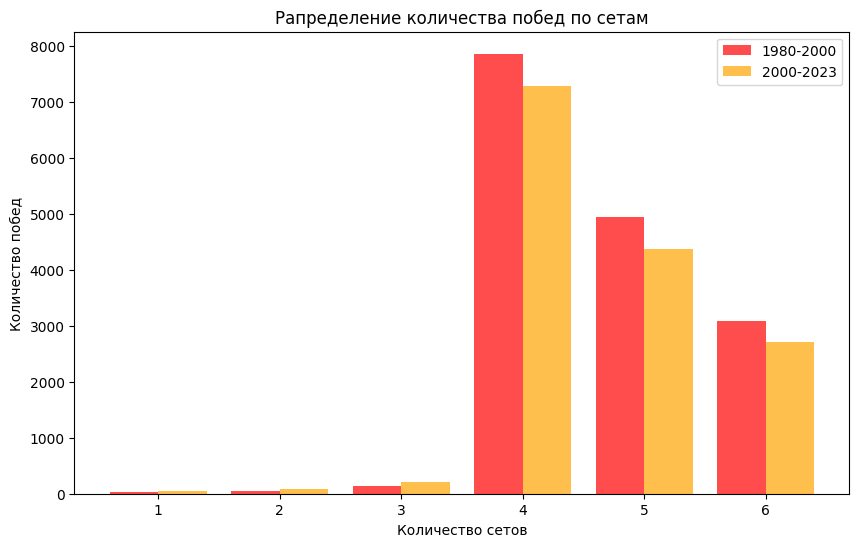

In [45]:
# Рапределение количества сетов best_of ==5, всего
# Фильтрация данных по годам
task_03_1980_2001 = task_03[(task_03['year'] >= 1980) & (task_03['year'] <= 2001)].reset_index(drop=True)
task_03_2002_2023 = task_03[(task_03['year'] > 2001) & (task_03['year'] <= 2023)].reset_index(drop=True)

# Создание позиций для баров
positions = range(1, max(task_03['sets_count']) + 2, 1)

# Построение гистограммы для каждой группы с разными цветами
plt.figure(figsize=(10, 6))
plt.bar([pos - 0.2 for pos in positions], 
        task_03_1980_2001['sets_count'].value_counts().sort_index(), 
        width=0.4, 
        color='red', 
        alpha=0.7, 
        label='1980-2000')
plt.bar([pos + 0.2 for pos in positions], 
        task_03_2002_2023['sets_count'].value_counts().sort_index(), 
        width=0.4, 
        color='orange', 
        alpha=0.7, 
        label='2000-2023')

plt.title('Рапределение количества побед по сетам')
plt.xlabel('Количество сетов')
plt.ylabel('Количество побед')
plt.legend()
plt.show()

### Графическое описание распределений признака для каждой выборки

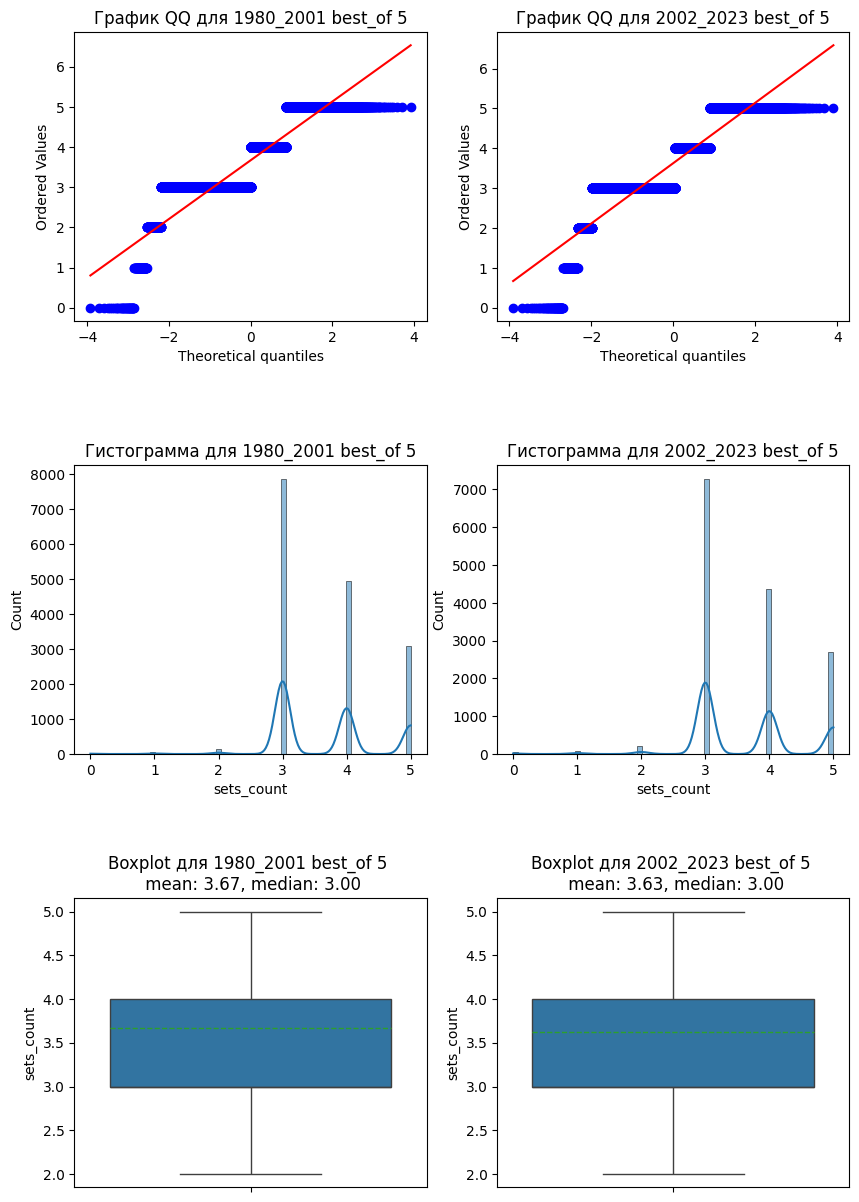

In [46]:
plot_sample_data(task_03_1980_2001.sets_count, task_03_2002_2023.sets_count, title_a='1980_2001 best_of 5', title_b='2002_2023 best_of 5')

In [47]:
# Сравнение среднего количества побед

print(f"Среднее количество сетов для побед в периоде 1980-2001: {task_03_1980_2001.sets_count.mean()}, общее количество партий: {len(task_03_1980_2001.sets_count)}")
print(f"Среднее количество сетов для побед в периоде 2002-2023: {task_03_2002_2023.sets_count.mean()}, общее количество партий: {len(task_03_2002_2023.sets_count)}")

Среднее количество сетов для побед в периоде 1980-2001: 3.6685703643925756, общее количество партий: 16109
Среднее количество сетов для побед в периоде 2002-2023: 3.628614191441595, общее количество партий: 14699


### Статистический тест на нормальность

In [48]:
shapiro_test(task_03_1980_2001.sets_count, task_03_2002_2023.sets_count, alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


Примем с работе, что выборки все же нормально распределены, на основании графического представления. QQ plot и boxplot отражают это наиболее ясно.

### Z тест

Обоснование выбора теста:

Z-тест подходит для сравнения средних двух независимых выборок, когда выполнены следующие условия:

Большой объем выборок: Для каждой из выборок количество наблюдений достаточно велико (обычно более 30), что позволяет применять Центральную предельную теорему.

Распределение выборочных средних близко к нормальному: Предполагается, что данные распределены нормально, или что из-за большого размера выборок распределение средних можно считать нормальным на основании Центральной предельной теоремы.

Известные или предполагаемые равные дисперсии: Значения в выборках должны иметь примерно одинаковые дисперсии. Если дисперсии сильно отличаются, следует использовать другие виды тестов (например, t-тест Уэлча).

Независимость выборок: Наблюдения в одной выборке не должны влиять на наблюдения в другой.
В вашем случае, сравнение среднего количества сетов для победы между двумя временными периодами (1980-2001 и 2002-2023) с большим количеством данных (60 000 наблюдений) подходит под эти критерии. Допущение о нормальности распределения усиливается благодаря большому размеру выборки и предположению о том, что выборочные средние будут распределены нормально.

Также, предполагается, что данные за разные годы независимы, что является важным условием для z-теста. И хотя дисперсии могли измениться со временем, z-тест может быть использован как первичная проверка различий между средними, особенно при больших объемах данных, когда влияние несоответствия дисперсий снижается.

Если дисперсии выборок неизвестны или предположение о равенстве дисперсий сомнительно, можно использовать t-тест с поправкой Уэлча, который не требует равенства дисперсий.

In [49]:
# Нулевая гипотеза: среднее значение первой выборки меньше или равно среднему значению второй выборки
# Альтернативная гипотеза: среднее значение первой выборки больше среднего значения второй выборки

# Проведем z-тест
z_stat, p_value = ztest(task_03_1980_2001.sets_count, task_03_2002_2023.sets_count, alternative='larger')

print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

# Установим уровень значимости, например, 0.05
alpha = 0.05

# Проверим нулевую гипотезу
if p_value < alpha:
    print("Отвергаем нулевую гипотезу - есть достаточные доказательства, что среднее первой выборки 1980_2001 больше среднего второй 2002_2023")
else:
    print("Не отвергаем нулевую гипотезу - нет достаточных доказательств считать среднее первой выборки 1980_2001 большим")

Z-statistic: 4.225681445684541
P-value: 1.1910939311081864e-05
Отвергаем нулевую гипотезу - есть достаточные доказательства, что среднее первой выборки 1980_2001 больше среднего второй 2002_2023


### Вывод по задаче 03

На основании графического распределения данных и вопреки результату теста Шапиро принимаем версию о нормальном распределении значений количества сетов в выборках.

Проведенный z тест позволяет утверждать - среднее первой выборки 1980_2001 больше среднего второй 2002_2023

Среднее количество сетов для любого игрока чтобы победить уменьшается со временем - верно.

## Задача_04

Вы хотите изучить психологическую устойчивость профессиональных игроков в теннис. Одним из важных показателей такой устойчивости будет доля выигранных брейк-поинтов. Возьмите трех игроков (они необязательно должны играть в одно и то же время. Можете взять игроков, которые сильно отличаются по рангу, а можете взять примерно равных игроков), для каждого из них посчитайте долю выигранных брейк поинтов (колонки, заканчивающиеся на bpFaced и bpSaved) отдельно в победных и проигранных матчах за минимум 10 лет (можно больше, но годы должны идти подряд). Постройте box-plot’ы для этих статистик для каждого из игроков. Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Выбор статистического теста обоснуйте.

 Выберите трех игроков с разным рангом или примерно равным уровнем игры.
- Для каждого игрока соберите данные о сыгранных матчах за период минимум 10 лет подряд. Данные должны включать количество брейк-поинтов, полученных игроком (bpFaced), и количество отыгранных брейк-поинтов (bpSaved) в каждом матче.
- Для каждого игрока разделите матчи на две группы: выигранные и проигранные.
- Посчитайте долю выигранных брейк-поинтов в каждой группе матчей за каждый год: Доля выигранных брейк-поинтов = bpSaved / bpFaced

### Подготовка выборки для задачи

In [50]:
# Создание выборки к задаче
combined_df = pd.read_csv('full_data/combined_atp_matches.csv')
task_04 = combined_df[['year', 'winner_id', 'loser_id', 'w_bpSaved', 'w_bpFaced', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'loser_rank']].dropna()

# Отбор трех игроков по количеству матчей что они сыграли
ids = list(task_04.winner_id.value_counts().head(3).index)

(task_04[task_04['winner_id']
         .isin(ids)]
         .groupby('winner_id')
         .agg({'winner_id':'count', 'winner_id':'count', 'winner_rank':'max'})
         .rename(columns={'winner_id':'winns_count', 'winner_rank':'winner_rank_max'}))

task_04['game_result'] = task_04.apply(lambda x: 1 if x['winner_id'] in ids else 0 if x['loser_id'] in ids else None, axis=1)
task_04 = (task_04[(task_04['winner_id'].isin(ids)) | 
                          (task_04['loser_id'].isin(ids))])
task_04['winned_bp'] = (task_04.apply(lambda x: 
                                                    round(x['w_bpSaved'] / x['w_bpFaced'] * 100, 1) if x['game_result'] == 1
                                                    else round(x['l_bpSaved'] / x['l_bpFaced'] * 100, 1) if x['game_result'] == 0 else None, axis=1))
task_04 = task_04.dropna()

df_info(task_04)

Количество записей: 	 3344
Количество столбцов: 	 11
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 11:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 3344 entries, 115195 to 191759
Columns: 11 entries, year to winned_bp
dtypes: float64(8), int64(3)
memory usage: 313.5 KB


None

Первые 3 строки:


,year,winner_id,loser_id,w_bpSaved,w_bpFaced,l_bpSaved,l_bpFaced,winner_rank,loser_rank,game_result,winned_bp
115195,1998,102463,103819,1.0,3.0,1.0,5.0,88.0,702.0,0.0,20.0
116251,1998,103819,101703,1.0,1.0,4.0,8.0,878.0,45.0,1.0,100.0
116260,1998,103819,101735,4.0,4.0,8.0,10.0,878.0,43.0,1.0,100.0


Для отбора временного окна, где для каждого игрока есть данные и о победах и опоражениях графически посмотрим на распределение побед и поражений

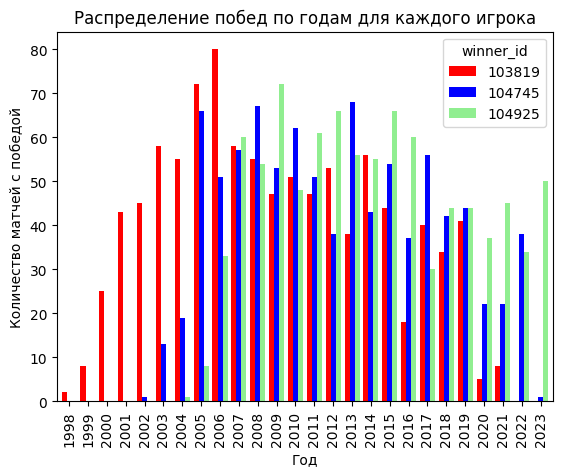

In [51]:
win_plot = task_04[task_04.game_result == 1].groupby(['year', 'winner_id']).size().unstack().plot(kind='bar', stacked=False, width=0.8, color=['red', 'blue', 'lightgreen']);
win_plot.set_title('Распределение побед по годам для каждого игрока');
win_plot.set_xlabel('Год');
win_plot.set_ylabel('Количество матчей с победой');

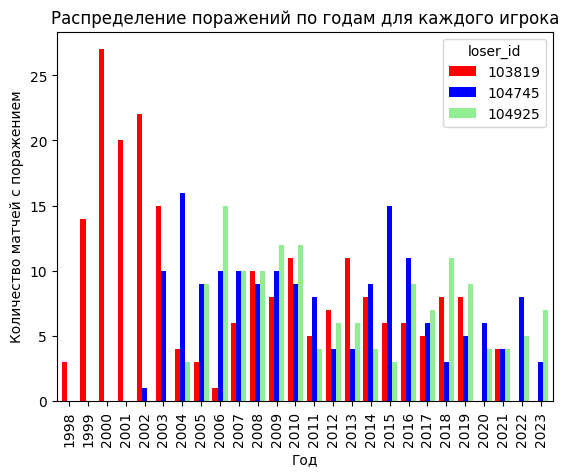

In [52]:
lose_plot = task_04[task_04.game_result == 0].groupby(['year', 'loser_id']).size().unstack().plot(kind='bar', stacked=False, width=0.8, color=['red', 'blue', 'lightgreen']);
lose_plot.set_title('Распределение поражений по годам для каждого игрока');
lose_plot.set_xlabel('Год');
lose_plot.set_ylabel('Количество матчей с поражением');

In [53]:
# выбираем  временное окно 2005-2015
task_04 = task_04[(task_04['year'] >= 2005) & (task_04['year'] <= 2015)]
df_info(task_04)

Количество записей: 	 2054
Количество столбцов: 	 11
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 11:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 2054 entries, 136510 to 170263
Columns: 11 entries, year to winned_bp
dtypes: float64(8), int64(3)
memory usage: 192.6 KB


None

Первые 3 строки:


,year,winner_id,loser_id,w_bpSaved,w_bpFaced,l_bpSaved,l_bpFaced,winner_rank,loser_rank,game_result,winned_bp
136510,2005,104745,103812,0.0,1.0,3.0,6.0,2.0,42.0,1.0,0.0
136526,2005,104745,103990,0.0,1.0,2.0,6.0,2.0,17.0,1.0,0.0
136534,2005,104745,103285,3.0,4.0,2.0,4.0,2.0,14.0,1.0,75.0


In [54]:
# Сбор общей статистики по игрокам
result = []
for gamer_id in ids:
    for game_result in task_04.game_result.unique():
        df = (task_04[(task_04.game_result == game_result) & 
                      ((task_04.winner_id == gamer_id) | (task_04.loser_id == gamer_id))])
        df = df.groupby(['year'])['winned_bp'].mean().reset_index()
        # Set the column name to "<gamer_id>_<result>"
        column_name = f"{gamer_id}_{game_result}"
        df.rename(columns={'winned_bp': column_name}, inplace=True)
        df.set_index('year', inplace=True)
        result.append(df)

# Concatenate the result dataframes on the columns
task_04_result_df = pd.concat(result, axis=1)
task_04_result_df

,103819_1.0,103819_0.0,104925_1.0,104925_0.0,104745_1.0,104745_0.0
year,,,,,,
2005,64.243836,40.300000,67.000000,54.100000,62.619403,50.466667
2006,66.363095,50.000000,61.560000,52.073333,70.866038,50.320000
2007,64.980328,52.983333,69.075000,56.270000,70.122581,56.760000
2008,71.783333,58.490000,67.315000,59.780000,64.375362,49.877778
2009,74.607843,52.262500,65.311688,57.783333,66.294643,54.110000
2010,70.996226,54.245455,67.857407,56.100000,65.139683,48.200000
2011,65.290741,61.840000,65.045161,36.925000,63.628070,47.150000
2012,74.124561,46.742857,66.338571,49.716667,72.132500,38.750000
2013,69.852273,60.663636,65.454237,61.050000,69.810000,69.825000


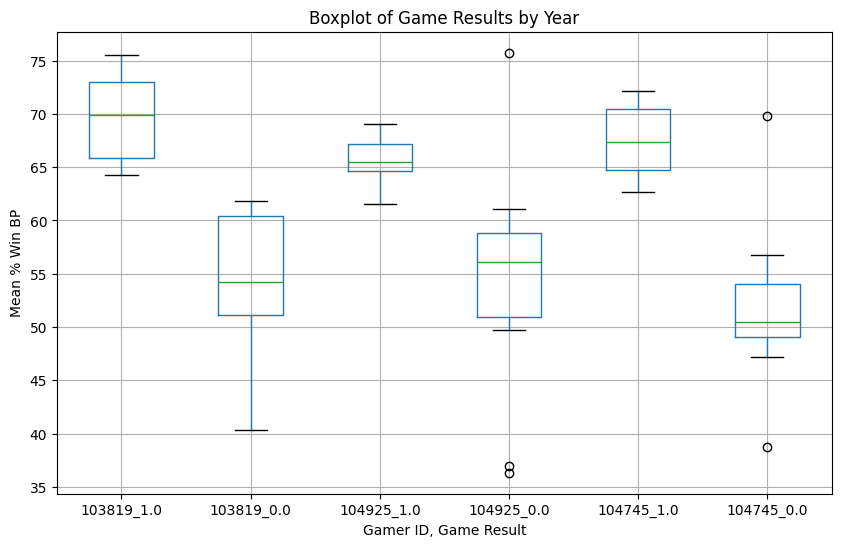

In [55]:
# Создание боксплотов
ax = task_04_result_df.boxplot(figsize=(10, 6))
ax.set_title('Boxplot of Game Results by Year')
ax.set_xlabel('Gamer ID, Game Result')
ax.set_ylabel('Mean % Win BP')
plt.show()

###  Обоснование выбора тестов

Для того чтобы выяснить, независимо ли распределение метрики winned_bp по годам для каждого игрока, можно использовать следующие статистические тесты:

* Для одного игрока (внутригрупповой анализ):

Чтобы проверить независимость распределения winned_bp по годам для победных и проигранных матчей одного игрока, можно использовать `двусторонний хи-квадрат тест независимости`. Этот тест сравнит частоты winned_bp для победных и проигранных матчей по каждому году.

* Между игроками (межгрупповой анализ):
Для сравнения средних значений метрики winned_bp между игроками для выигранных матчей и отдельно для проигранных матчей можно использовать `однофакторный ANOVA тест`, если предполагается, что данные распределены нормально и дисперсии равны.

Если данные не соответствуют предпосылкам нормальности или гомоскедастичности, следует использовать непараметрический тест, например, Краскела-Уоллиса.

Перед применением статистических тестов, необходимо проверить предпосылки:

`Нормальность распределения`: QQ-plot или тесты нормальности, такие как Шапиро-Уилка.

`Равенство дисперсий`: тест Левена или Бартлетта.

После проверки предпосылок выбираем соответствующий статистический тест. Если предпосылки не выполняются, используем соответствующие непараметрические тесты.

1. Проверить предположение о независимости распределений по годам для каждого игрока с помощью теста Краскела-Уоллиса. Это непараметрический аналог одностороннего дисперсионного анализа (ANOVA), который не требует предположения о нормальном распределении данных. Нулевая гипотеза: распределения по годам идентичны для каждого игрока, альтернативная: по крайней мере одно распределение отличается от остальных.



In [56]:
H0 = 'распределения по годам идентичны для каждого игрока'
H1 = 'по крайней мере одно распределение отличается от остальных'

def run_kruskal_test(player_id, task_04_result_df):
    statistic, p_value = kruskal(task_04_result_df[f'{player_id}_1.0'], task_04_result_df[f'{player_id}_0.0'])
    result = f"Отвергаем нулевую гипотезу. Принимаем гипотезу {H1}" if p_value < 0.05 else f"Принимаем альтернативную гипотезу {H1}"
    print(f"Для игрока {player_id}: {result}")

for player in ids:
    run_kruskal_test(player, task_04_result_df)

Для игрока 103819: Отвергаем нулевую гипотезу. Принимаем гипотезу по крайней мере одно распределение отличается от остальных
Для игрока 104925: Отвергаем нулевую гипотезу. Принимаем гипотезу по крайней мере одно распределение отличается от остальных
Для игрока 104745: Отвергаем нулевую гипотезу. Принимаем гипотезу по крайней мере одно распределение отличается от остальных


2. Для сравнения долей выигранных брейк-поинтов между игроками можно использовать тест Краскела-Уоллиса для независимых выборок. Проверяем гипотезу о том, что средние доли выигранных брейк-поинтов одинаковы для всех игроков, отдельно для проигранных и выигранных матчей. Если обнаруживается значимое различие, то можно провести попарные сравнения с помощью теста Манна-Уитни с поправкой Бонферрони.

In [57]:
def run_kruskal_wallis_test(task_04_result_df):
    
    for player in ids:
        player_data = task_04_result_df[[f'{player}_1.0', f'{player}_0.0']]
        statistic, p_value = kruskal(player_data[f'{player}_1.0'], player_data[f'{player}_0.0'])
        result = "Отвергаем нулевую гипотезу: средние доли выигранных брейк-поинтов различны." if p_value < 0.05 else "Принимаем нулевую гипотезу: средние доли выигранных брейк-поинтов одинаковы."
        print(f"Для игрока {player}: {result}")

    # Попарные сравнения с помощью теста Манна-Уитни с поправкой Бонферрони
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            player1_data = task_04_result_df[[f'{ids[i]}_1.0', f'{ids[i]}_0.0']]
            player2_data = task_04_result_df[[f'{ids[j]}_1.0', f'{ids[j]}_0.0']]
            _, p_value = mannwhitneyu(player1_data[f'{ids[i]}_1.0'], player2_data[f'{ids[j]}_1.0'], alternative='two-sided')
            adjusted_p_value = p_value * len(ids) * (len(ids) - 1) / 2  # Поправка Бонферрони
            comparison_result = "Отвергаем нулевую гипотезу: средние доли выигранных брейк-поинтов различны." if adjusted_p_value < 0.05 else "Принимаем нулевую гипотезу: средние доли выигранных брейк-поинтов одинаковы."
            print(f"Сравнение для игроков {ids[i]} и {ids[j]}: {comparison_result}")

run_kruskal_wallis_test(task_04_result_df)

Для игрока 103819: Отвергаем нулевую гипотезу: средние доли выигранных брейк-поинтов различны.
Для игрока 104925: Отвергаем нулевую гипотезу: средние доли выигранных брейк-поинтов различны.
Для игрока 104745: Отвергаем нулевую гипотезу: средние доли выигранных брейк-поинтов различны.
Сравнение для игроков 103819 и 104925: Принимаем нулевую гипотезу: средние доли выигранных брейк-поинтов одинаковы.
Сравнение для игроков 103819 и 104745: Принимаем нулевую гипотезу: средние доли выигранных брейк-поинтов одинаковы.
Сравнение для игроков 104925 и 104745: Принимаем нулевую гипотезу: средние доли выигранных брейк-поинтов одинаковы.


### Выводы по задаче 04

Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков?  - Являются.

Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Разницы нет.

## Задача_05

У вас есть гипотеза, что доля выигранных брейк-поинтов связана с вероятностью победить в игре. Соберите статистику, где для каждого матча будет собран его исход (победа/поражение) и доля выигранных брейк-поинтов (не забудьте, что в матче два игрока). Разделите долю выигранных брейкпоинтов на группы выше/ниже медианы и, используя информацию о исходе матча, проверьте зависимость между количеством выигранных брейкпоинтов и результатом матча. Насколько сильна эта зависимость? Выбор статистического теста обоснуйте.

1. Создайте новый признак, который будет отражать долю выигранных брейк-поинтов для каждого игрока в матче. Для этого используйте следующую формулу:

Доля выигранных брейк-поинтов = (wbpSaved + lbpSaved) / (wbpFaced + lbpFaced)

2. После этого разделите выборку на две группы: матчи, где игроки выиграли брейк-поинты больше или равно медианы, и матчи, где они выиграли меньше медианы.

3. Составьте таблицу сопряжённости, где строки будут представлять долю выигранных брейк-поинтов (выше/ниже медианы), а столбцы — исход матча (победа/поражение).

Надо для каждого игрока собрать данные о брейк-поинтах (колонки bpFaced и bpSaved) за минимум 10 лет подряд, отдельно для победных и проигранных матчей.
Посчитать долю выигранных брейк-поинтов (bpSaved / bpFaced) для каждого игрока, отдельно для победных и проигранных матчей по годам.
Можно сделать по принципе задания 4.

In [58]:
# Создание выборки для задачи
combined_df = pd.read_csv('full_data/combined_atp_matches.csv')

# Выбор определенных столбцов и удаление строк с отсутствующими значениями
task_05 = combined_df[['year', 'winner_id', 'loser_id', 'w_bpSaved', 'w_bpFaced', 'l_bpSaved', 'l_bpFaced']].dropna()

# Вычисление показателей соотношения брейк-поинтов
task_05['bp_ratio_winner'] = round((task_05['w_bpSaved'] / task_05['w_bpFaced'] * 100), 1)
task_05['bp_ratio_loser'] = round((task_05['l_bpSaved'] / task_05['l_bpFaced'] * 100), 1)

# Удаление строк с отсутствующими значениями
task_05 = task_05.dropna()

# Создание DataFrame для победителей и проигравших
winners = task_05[['year', 'winner_id', 'bp_ratio_winner']].rename(columns={'winner_id': 'id', 'bp_ratio_winner': 'bp_ratio'})
losers = task_05[['year', 'loser_id', 'bp_ratio_loser']].rename(columns={'loser_id': 'id', 'bp_ratio_loser': 'bp_ratio'})

# Добавление столбца 'result'
winners['result'] = 1
losers['result'] = 0

# Удаление дублирующихся строк
task_05 = task_05.drop_duplicates()

# Объединение DataFrame
task_05 = pd.concat([winners, losers], ignore_index=True)
task_05 = task_05.drop_duplicates()

# Вычисление медианы показателя брейк-поинтов для победителей и проигравших
losers_median = losers.bp_ratio.median()
winners_median = winners.bp_ratio.median()

# Создание столбца 'breakpoints_level'
task_05['breakpoints_level'] = (task_05
                           .apply(lambda x: 
                                  'more median' if (x['bp_ratio'] >= winners_median and x['result'] == 1) else 
                                  'less median' if (x['bp_ratio'] < winners_median and x['result'] == 1) else 
                                  'more median' if (x['bp_ratio'] >= losers_median and x['result'] == 0) else 
                                  'less median' if (x['bp_ratio'] < losers_median and x['result'] == 0) else '', axis=1))

df_info(task_05)  # Отображение информации о DataFrame
print(winners_median, losers_median)

Количество записей: 	 114879
Количество столбцов: 	 5
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 5:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 114879 entries, 0 to 172719
Columns: 5 entries, year to breakpoints_level
dtypes: float64(1), int64(3), object(1)
memory usage: 5.3+ MB


None

Первые 3 строки:


,year,id,bp_ratio,result,breakpoints_level
0,1991,101723,50.0,1,less median
1,1991,100946,90.0,1,more median
2,1991,101234,100.0,1,more median


66.7 53.3


In [59]:
task_05.groupby('result')['breakpoints_level'].value_counts().unstack()

breakpoints_level,less median,more median
result,,
0,30556,35615
1,22003,26705


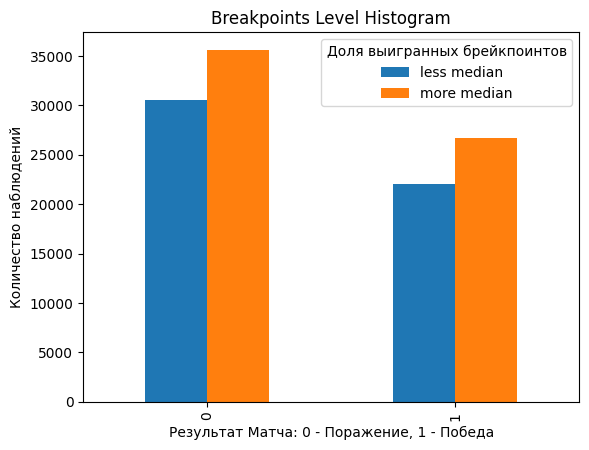

In [60]:
count_of_games = task_05.groupby('result')['breakpoints_level'].value_counts().unstack().plot(kind='bar')
count_of_games.set_title('Breakpoints Level Histogram')
plt.xlabel('Результат Матча: 0 - Поражение, 1 - Победа')
plt.ylabel('Количество наблюдений')
plt.legend(title='Доля выигранных брейкпоинтов')
plt.show()


In [61]:
count_of_games = task_05.groupby('result')['breakpoints_level'].value_counts().unstack()
count_of_games

breakpoints_level,less median,more median
result,,
0,30556,35615
1,22003,26705


In [62]:
count_of_games['less median'][0]

30556

### Обоснование выбора теста

Парный Z-тест используется для сравнения средних значений двух связанных выборок. В вашем случае, если у вас есть две выборки, например, значения "breakpoints_level" для двух разных медианных значений "less median" и "more median", вы можете использовать парный Z-тест, чтобы определить, есть ли статистически значимая разница между этими двумя значениями.

In [63]:
# нулевая и альтернативная гипотезы
H0 = 'Соотношения долей брейкпоинтов (больше / меньше медианы) -  в группах 0 и 1 равны'
H1 = 'Доля брейкпоинтов больше медианы -  в группе 0 выше, чем в группе 1'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=count_of_games['less median'],  
    nobs=count_of_games['more median'],  
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value:  0.0
Отвергаем нулевую гипотезу. Соотношения долей брейкпоинтов (больше / меньше медианы) -  в группах 0 и 1 равны
Альтернативная гипотеза. H1: Доля брейкпоинтов больше медианы -  в группе 0 выше, чем в группе 1


### Вывод по задаче 5

Доля выигранных брейк-поинтов связана с вероятностью победить в игре./